In [6]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import os
import pandas as pd
import torch
from transformers import AutoTokenizer

In [9]:
import nltk
chunks = []
authors = []
device = torch.device('cuda')
nltk.download('punkt_tab')
model_name = "cointegrated/rubert-tiny"  # Легкая версия ruBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_tokens = 512
chunk_size = 5 # количество предложений, которые будут входить в 1 запись в датафрейме для дальнейшего обучения
author_dir = 'authors'
train_dir = 'train'
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
# проходим по всем 6 файлам, преобрабатываем текст, разделяем на предложения, добавляем в датафрейм
for file in os.listdir(author_dir):
    """
    Не было проведено аугментации, удаления редких слов, удаления символов, лемминга и стемминга, так как
    показалось, что удалив может пропасть авторский стиль (например много тире в тексте - значит диалог, авторский прием,
    много ! в тексте - тоже не у каждого автора)
    """
    author = file.split('.')[0]
    path = os.path.join(author_dir, file)
    with open(path, encoding='utf-8') as f:
        text = f.read()
        text = text.lower() # преобразование всего текста в нижний регистр чтобы не было повторений например Текст, текст
        text = " ".join([word for word in text.split() if word not in stop_words]) # удаление разных и в на к от (неинформативно)
        sentences = sent_tokenize(text, language="russian")
        for i in range(0, len(sentences), chunk_size):
            chunk = " ".join(sentences[i:i+chunk_size])
            if len(tokenizer(chunk)["input_ids"]) <= max_tokens:
                chunks.append(chunk)
                authors.append(author)

df = pd.DataFrame({
    'chunk': chunks,
    'author': authors
})

Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors


In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).to("cuda")

# Функция для токенизации текста
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512)

# Применение токенизации ко всем строкам
df['input_ids'] = df['chunk'].apply(lambda x: tokenize_function(x)['input_ids'])
df['attention_mask'] = df['chunk'].apply(lambda x: tokenize_function(x)['attention_mask'])

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
author_to_id = {'Bradbury': 0, 'Bulgakov': 1, 'Fry': 2, 'Genri': 3, 'Simak': 4, 'Strugatskie': 5}
df['labels'] = df['author'].map(author_to_id)

In [13]:
from sklearn.model_selection import train_test_split

# Разделяем на обучающую и тестовую выборки
train_texts, val_texts, train_labels, val_labels = train_test_split(df['chunk'], df['labels'], test_size=0.2, shuffle=True)

In [14]:
import torch
from torch.utils.data import Dataset

class AuthorDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Создаём датасет для обучения
train_dataset = AuthorDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = AuthorDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)


In [15]:
from transformers import Trainer, TrainingArguments

# Параметры обучения
training_args = TrainingArguments(
    output_dir='./results',          # Куда сохранять модель
    num_train_epochs=3,              # Количество эпох
    per_device_train_batch_size=8,   # Размер батча для тренировки
    per_device_eval_batch_size=8,    # Размер батча для валидации
    warmup_steps=500,                # Количество шагов разогрева
    weight_decay=0.01,               # Регуляризация
    logging_dir='./logs',            # Логирование
    logging_steps=10,
    eval_strategy="epoch",           # Оценка после каждой эпохи
    fp16=True
)

# Создаем Trainer
trainer = Trainer(
    model=model,                         # Модель
    args=training_args,                  # Параметры обучения
    train_dataset=train_dataset,         # Обучающий датасет
    eval_dataset=val_dataset             # Валидационный датасет
)

# Обучаем модель
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: misterx-what (misterx-what-wedwe) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.588300,0.517732
2,0.298500,0.446364
3,0.272200,0.459155


TrainOutput(global_step=9924, training_loss=0.5630630665173073, metrics={'train_runtime': 730.9101, 'train_samples_per_second': 108.6, 'train_steps_per_second': 13.578, 'total_flos': 585647722506240.0, 'train_loss': 0.5630630665173073, 'epoch': 3.0})

In [16]:
from tqdm import tqdm

# Предсказания на тестовых текстах

predictions = []

for file in os.listdir(train_dir):
  with open(os.path.join(train_dir, file), "r", encoding="utf-8") as f:
        text = f.read()

  inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")
  with torch.no_grad():
      outputs = model(**inputs)
      probs = torch.nn.functional.softmax(outputs.logits, dim=1)
      predicted_class = torch.argmax(probs, dim=1).item()

  predicted_author = [k for k, v in author_to_id.items() if v == predicted_class]
  predictions.append((file, "".join(predicted_author).lower()))

df = pd.DataFrame(predictions, columns=["filename", "author"])
df.to_csv("predictions.csv", index=False)

🔎 Accuracy: 0.47619047619047616
🔎 F1-score (macro): 0.4547008547008547

📊 Classification Report:
              precision    recall  f1-score   support

    bradbury       0.00      0.00      0.00         3
    bulgakov       1.00      0.25      0.40         4
         fry       1.00      0.67      0.80         3
       genri       1.00      0.50      0.67         4
       simak       0.33      0.75      0.46         4
 strugatskie       0.29      0.67      0.40         3

    accuracy                           0.48        21
   macro avg       0.60      0.47      0.45        21
weighted avg       0.63      0.48      0.46        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


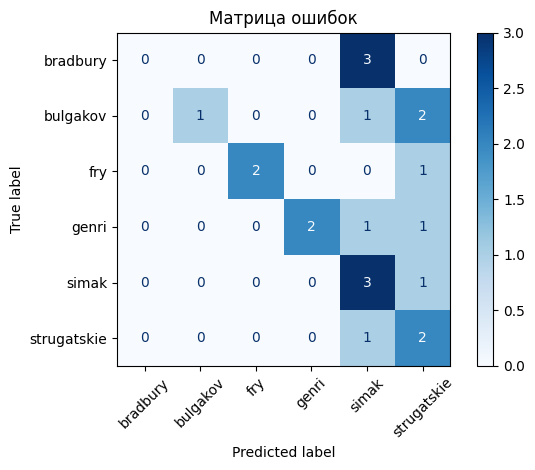

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-17-d49d6b572031>:43: FutureWarning

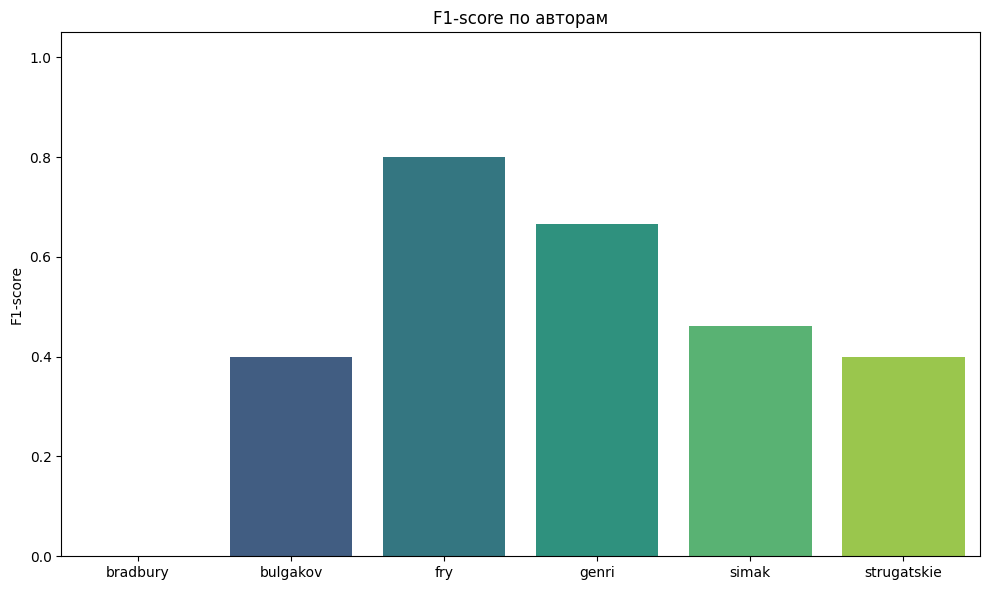

In [17]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Загрузка данных ===

pred_df = pd.read_csv("predictions.csv")
true_df = pd.read_csv("corrects.csv") # файл где содержатся верные авторы

# Объединим по имени файла
merged = pd.merge(pred_df, true_df, on='filename')
merged.columns = ['filename', 'predicted_author', 'true_author', 'class']

y_true = merged['true_author']
y_pred = merged['predicted_author']

# === 2. Метрики ===

print("🔎 Accuracy:", accuracy_score(y_true, y_pred))
print("🔎 F1-score (macro):", f1_score(y_true, y_pred, average='macro'))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

# === 3. Матрица ошибок ===

labels = sorted(y_true.unique())

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Матрица ошибок")
plt.tight_layout()
plt.show()

# === 4. Бар-чарты для F1-score по каждому  классу ===

report = classification_report(y_true, y_pred, output_dict=True)
f1_scores = {label: report[label]['f1-score'] for label in labels}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='viridis')
plt.ylabel('F1-score')
plt.title('F1-score по авторам')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()